!pip install finta gym gym_anytrading stable_baselines3 sb3_contrib pandas_datareader yfinance

In [1]:
import csv 
import time

# Data libraries
import pandas_datareader as data
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA

# Gym libraries
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

# Reinforcement learning libraries
from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common. callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

/opt/miniconda3/envs/tasi/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_epochs = ...
num_timesteps = ...
learning_rate = ...
# frame_bound = (>= window size, <=len(data))


# Collect the data

In [3]:
def get_data(dates, ticker=None):
    # read the data from yahoo finance API (yfinance)
    try: 
      panel_data = data.DataReader(ticker, "yahoo", dates[0], dates[1]).reset_index()
    except:
      panel_data = yf.Ticker(ticker)
      panel_data = panel_data.history(start=dates[0], end=dates[1]).reset_index()
    # df = pd.read_csv("gmedata.csv")

    # Define date as datetime
    panel_data["Date"] = pd.to_datetime(panel_data["Date"]).dt.date

    # Sort the dates in ascending order 
    panel_data.sort_values('Date', ascending=True, inplace=True)

    # Set index
    panel_data.set_index("Date", inplace=True)

    panel_data = panel_data[["High", "Low", "Open", "Close", "Volume"]]

    return panel_data

In [ ]:
# S&P 500 data
ticker = "^GSPC"
df = get_data(ticker=ticker, dates=["2000-05-01", "2022-12-01"])

In [4]:
df

,High,Low,Open,Close,Volume
Date,,,,,
2000-01-03,1478.000000,1438.359985,1469.250000,1455.219971,931800000
2000-01-04,1455.219971,1397.430054,1455.219971,1399.420044,1009000000
2000-01-05,1413.270020,1377.680054,1399.420044,1402.109985,1085500000
2000-01-06,1411.900024,1392.099976,1402.109985,1403.449951,1092300000
2000-01-07,1441.469971,1400.729980,1403.449951,1441.469971,1225200000
...,...,...,...,...,...
2022-11-25,4034.020020,4020.760010,4023.340088,4026.120117,1706460000
2022-11-28,4012.270020,3955.770020,4005.360107,3963.939941,3615430000
2022-11-29,3976.770020,3937.649902,3964.189941,3957.629883,3546040000


# Add indicators
* SMA
* RSI
* OBV

In [5]:
df["SMA"] = TA.SMA(df, 12)
df["RSI"] = TA.RSI(df)
df["OBV"] = TA.OBV(df)
df.fillna(0, inplace=True)

In [6]:
df

,High,Low,Open,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2000-01-03,1478.000000,1438.359985,1469.250000,1455.219971,931800000,0.000000,0.000000,0.000000e+00
2000-01-04,1455.219971,1397.430054,1455.219971,1399.420044,1009000000,0.000000,0.000000,-1.009000e+09
2000-01-05,1413.270020,1377.680054,1399.420044,1402.109985,1085500000,0.000000,4.935296,7.650000e+07
2000-01-06,1411.900024,1392.099976,1402.109985,1403.449951,1092300000,0.000000,7.387289,1.168800e+09
2000-01-07,1441.469971,1400.729980,1403.449951,1441.469971,1225200000,0.000000,48.207236,2.394000e+09
...,...,...,...,...,...,...,...,...
2022-11-25,4034.020020,4020.760010,4023.340088,4026.120117,1706460000,3960.370036,61.991034,1.235854e+12
2022-11-28,4012.270020,3955.770020,4005.360107,3963.939941,3615430000,3978.317525,55.739053,1.232239e+12
2022-11-29,3976.770020,3937.649902,3964.189941,3957.629883,3546040000,3978.422506,55.131402,1.228693e+12


# Split the data

In [7]:
def split_data(df):
    
    df_train = df[(df.index < sorted(df.index.values)[-int(0.2*len(sorted(df.index.values)))])]
    df_test = df[(df.index >= sorted(df.index.values)[-int(0.2*len(sorted(df.index.values)))])]
    
    return df_train, df_test

In [8]:
df_train, df_test = split_data(df)

In [9]:
def data_separated_plot(train_data: pd.DataFrame, test_data: pd.DataFrame):

    fig = plt.figure(figsize=(15, 12))
    st = fig.suptitle("Data Separation", fontsize=20)
    st.set_y(0.95)

    ax1 = fig.add_subplot(211)
    ax1.plot(train_data.index, train_data["Close"], label='Training data')
    ax1.plot(test_data.index, test_data["Close"], label='Test data')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Normalized Closing Returns')
    ax1.set_title("Close Price", fontsize=18)
    ax1.legend(loc="best", fontsize=12)
    ax1.grid(linestyle="--")

    ax2 = fig.add_subplot(212)
    ax2.plot(train_data.index, train_data["Volume"], label='Training data')
    ax2.plot(test_data.index, test_data["Volume"], label='Test data')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Normalized Volume Changes')
    ax2.set_title("Volume", fontsize=18)
    ax2.legend(loc="best", fontsize=12)
    ax2.grid(linestyle="--")

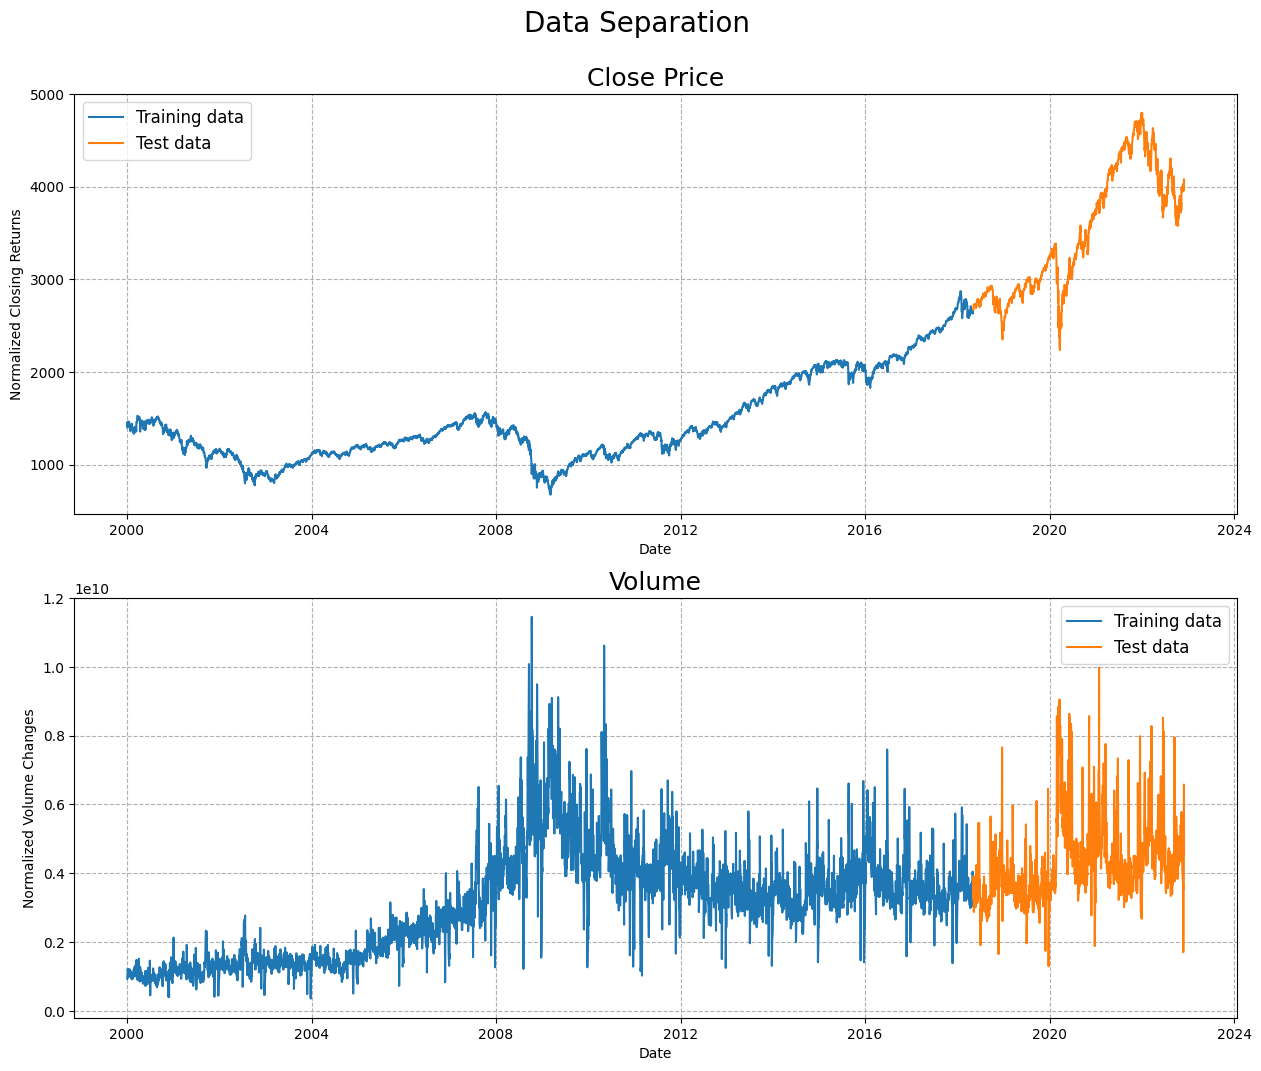

In [10]:
data_separated_plot(train_data=df_train, test_data=df_test)

# Environment Creation

## Add custom overlay to add the new signals to the environment

In [11]:
def add_signals(env):
    # calculate starting index, first value from the frame bound 0
    start = env.frame_bound[0] - env.window_size
    # end -> the frame bound 1
    end = env.frame_bound[1]
    # gets the prices of the low column
    prices = env.df.loc[:, "Close"].to_numpy()[start:end]
    # the features to keep
    signal_features = env.df.loc[:, ["Close", "Volume", "SMA", "RSI", "OBV"]].to_numpy()[start:end]
    return prices, signal_features

In [12]:
# inherit from the StocksEnv
class CustomEnv(StocksEnv):
    _process_data = add_signals
env2 = CustomEnv(df=df, window_size=128, frame_bound=(128, len(df_train)))

In [13]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

# Train the model

explain variance as high as possible, close to one
value loss as low as possible

Num epochs: 10
info {'total_reward': -366.997802734375, 'total_profit': 0.054934683125692337, 'position': 0}
Num epochs: 20
info {'total_reward': 165.510498046875, 'total_profit': 0.9137638174482325, 'position': 0}
Num epochs: 30
info {'total_reward': 1889.570068359375, 'total_profit': 0.40589606465088673, 'position': 1}
Num epochs: 40
info {'total_reward': 359.7734375, 'total_profit': 0.014177321745607577, 'position': 0}
Num epochs: 50
info {'total_reward': 2081.95263671875, 'total_profit': 0.10082781206000574, 'position': 1}
Num epochs: 60
info {'total_reward': -367.408935546875, 'total_profit': 0.033164480004269525, 'position': 1}
Num epochs: 70
info {'total_reward': 482.520751953125, 'total_profit': 0.10058378229572854, 'position': 1}
Num epochs: 80
info {'total_reward': 217.8203125, 'total_profit': 0.08187300169713446, 'position': 0}
Num epochs: 90
info {'total_reward': 1235.795166015625, 'total_profit': 0.06359029791023246, 'position': 1}
Num epochs: 100
info {'total_reward': -27

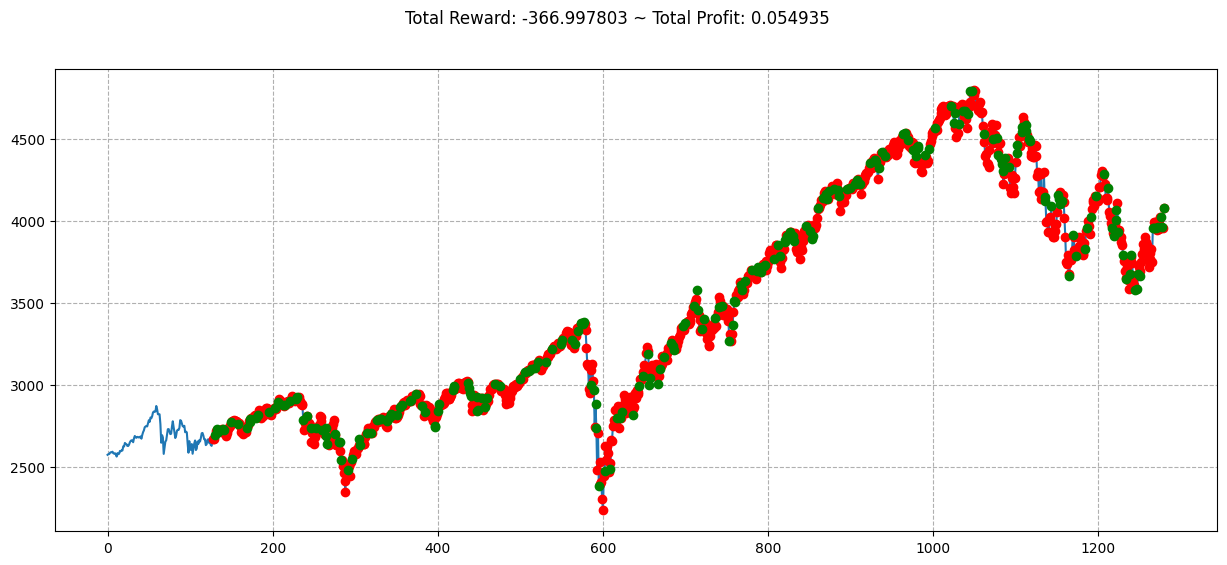

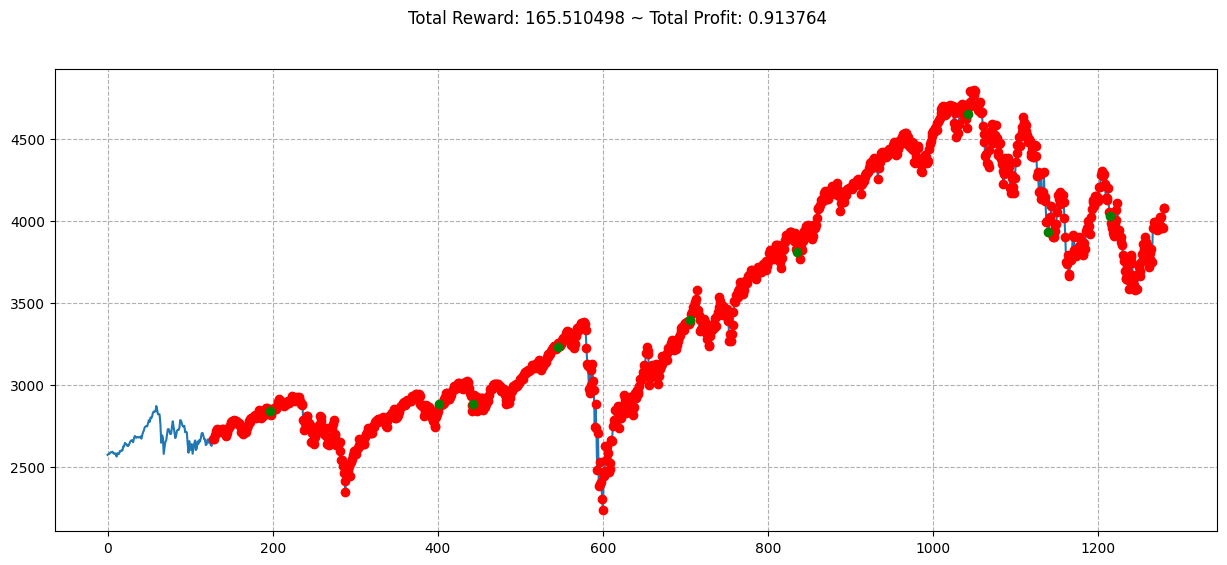

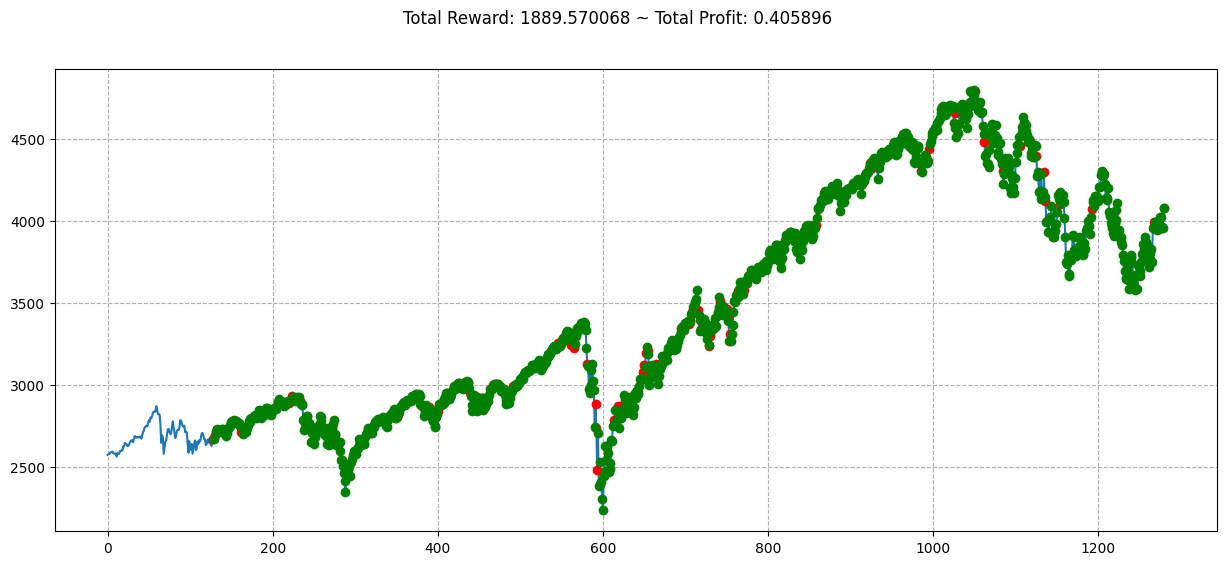

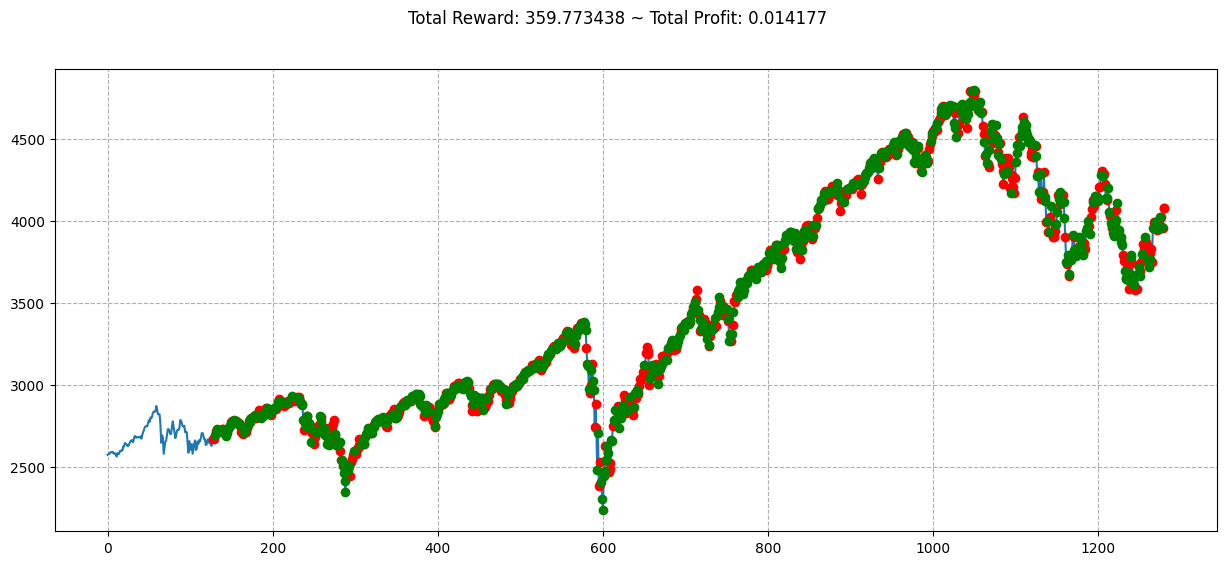

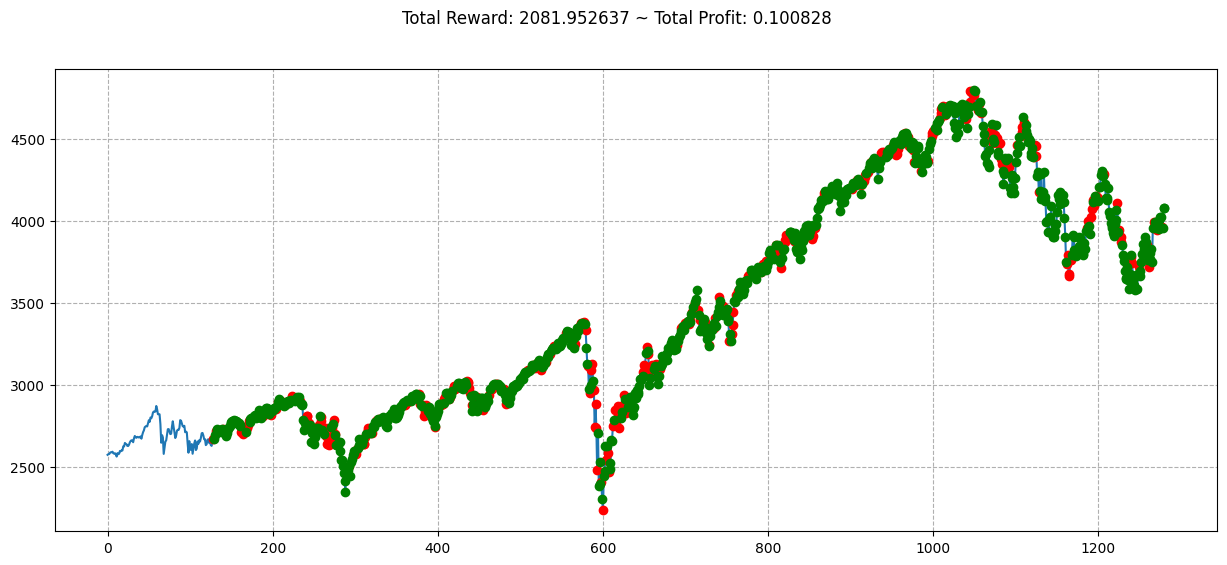

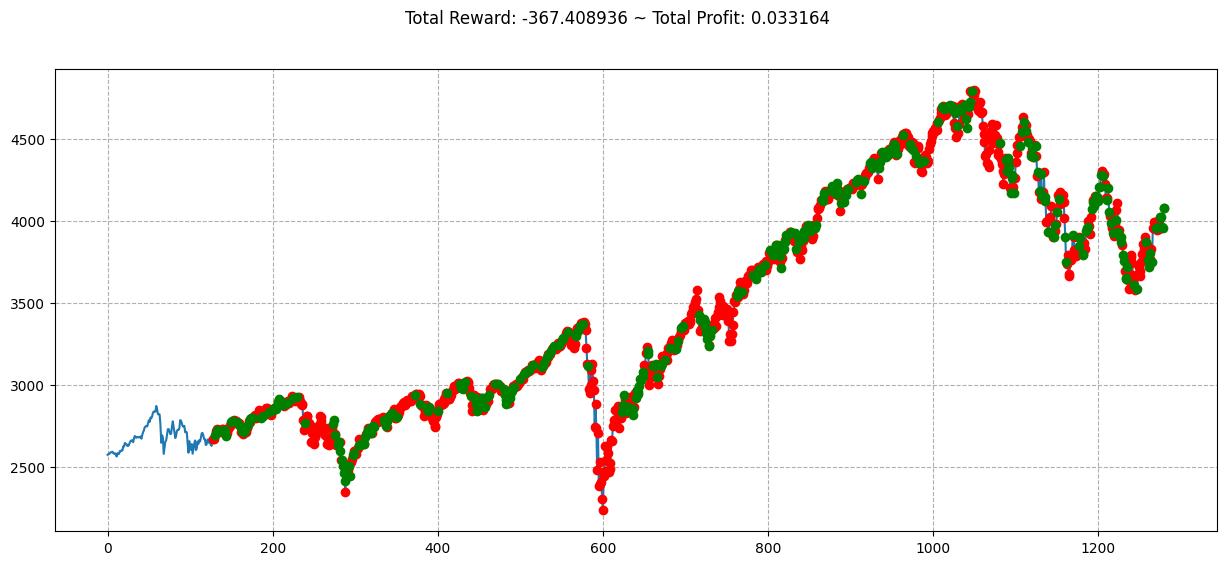

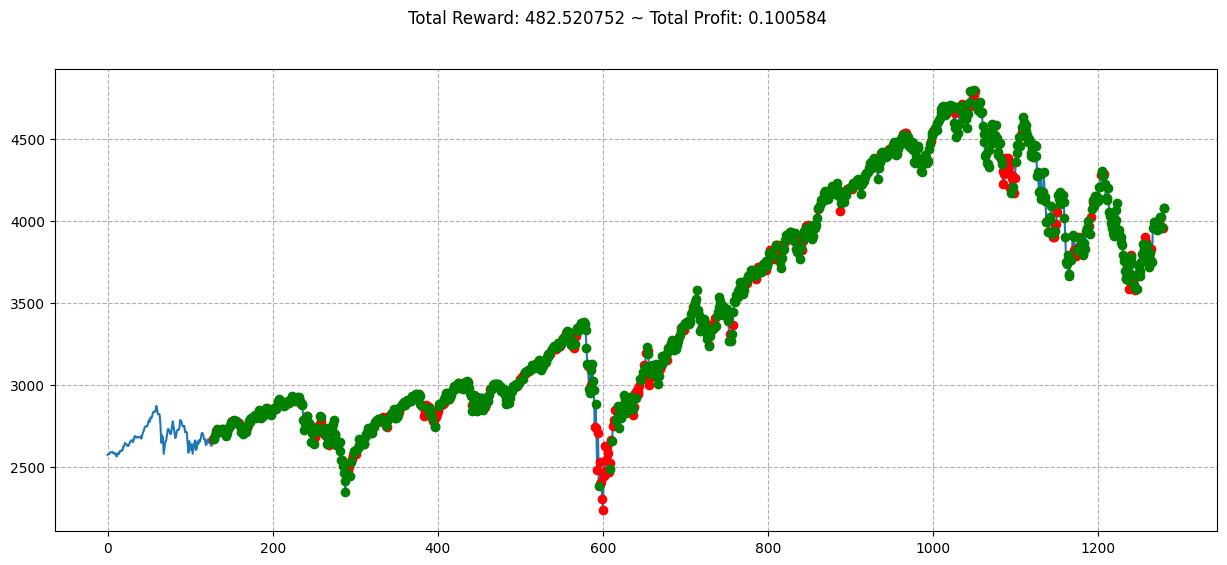

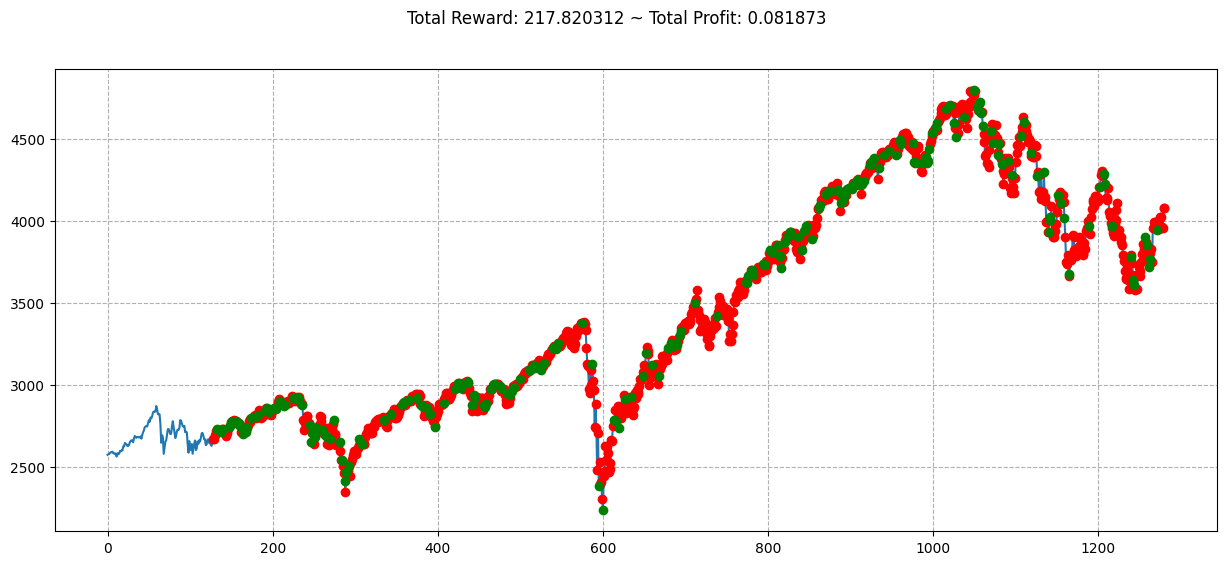

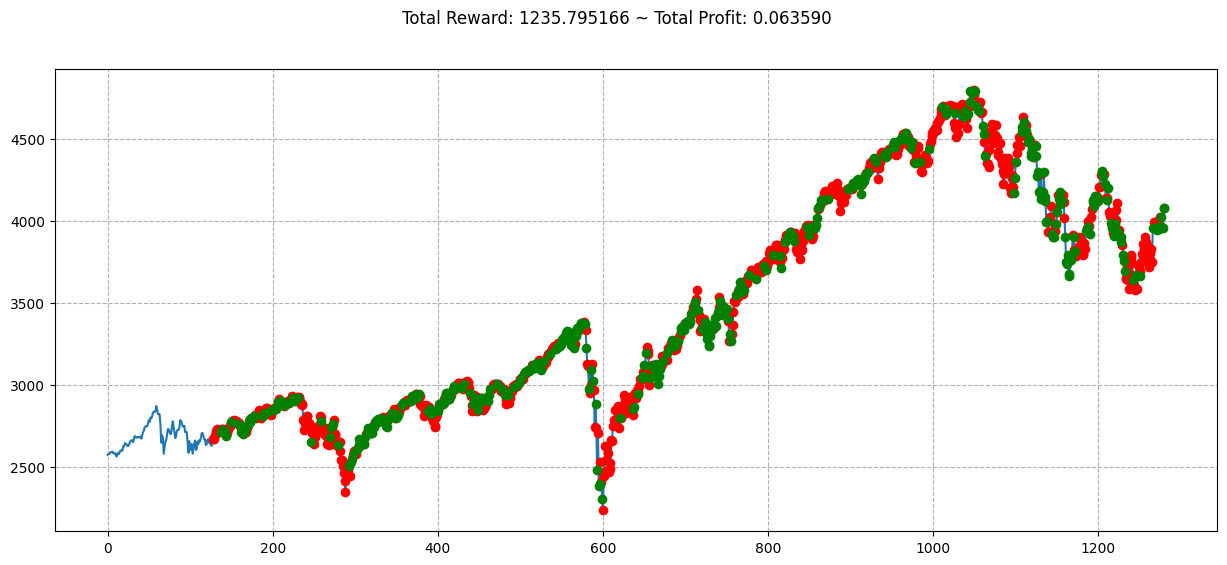

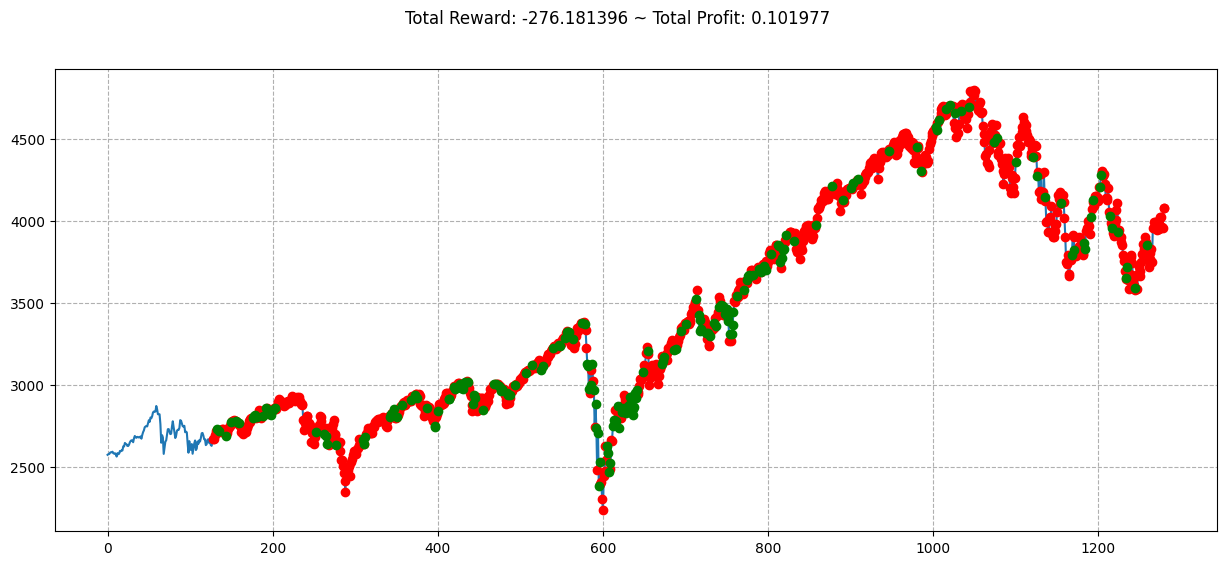

In [14]:
data = ["total_reward", "total_profit", "position", "num_epochs", "learning_rate", "num_time_steps", "time"]
with open('results/tables/results_indicators.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(data)

data_results = {
    "num_epochs": 0,
    "learning_rate": 0.001,
    "num_time_steps": 100_000
}

for epochs in range(10, 110, 10):

    start=time.time()

    data_results["num_epochs"] = epochs

    print(f"Num epochs: {epochs}")

    # Creation of the environment 
    env_maker = lambda: CustomEnv(df=df_train, window_size=128, frame_bound=(128, len(df_train)))
    env = DummyVecEnv([env_maker])

    # Training
    model = RecurrentPPO(policy="MlpLstmPolicy", env=env, verbose=0, learning_rate=0.001, batch_size=64, n_epochs=epochs)
    model.learn(total_timesteps=100_000)

    # Evaluate / Store the results
    env = CustomEnv(df=df, window_size=128, frame_bound=(len(df_train), len(df_train)+len(df_test)))
    obs = env.reset()
    while True:
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action=action)
        if done:
            print("info", info)
            break
    
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.grid(linestyle="--")
    plt.savefig(
        fname=f"results/images/PPO_LSTM_Indicators_{epochs}epochs.png", 
        dpi="figure", 
        format="png", 
        bbox_inches="tight",
        transparent=True
    )

    data_results["time"] = time.time() - start

    info.update(data_results)
    
    results = pd.DataFrame(info, index=[0])
    results.to_csv("results/tables/results_indicators.csv",mode="a", index=False, header=False)

Learning Rate: 0.0001
info {'total_reward': 576.90087890625, 'total_profit': 0.03177313828809392, 'position': 0}
Learning Rate: 0.0002
info {'total_reward': 720.55224609375, 'total_profit': 0.05841240932336117, 'position': 1}
Learning Rate: 0.0003
info {'total_reward': 2116.64697265625, 'total_profit': 0.04892116161712651, 'position': 0}
Learning Rate: 0.0004
info {'total_reward': 459.0126953125, 'total_profit': 0.019388950378652535, 'position': 1}
Learning Rate: 0.0005
info {'total_reward': 1835.329833984375, 'total_profit': 0.045439901958943686, 'position': 1}
Learning Rate: 0.0006
info {'total_reward': 1284.931884765625, 'total_profit': 0.040974215096097694, 'position': 1}
Learning Rate: 0.0007
info {'total_reward': -390.4228515625, 'total_profit': 0.04347514923496352, 'position': 0}
Learning Rate: 0.0008
info {'total_reward': 1649.48388671875, 'total_profit': 0.2560716672147925, 'position': 1}
Learning Rate: 0.0009
info {'total_reward': -24.376708984375, 'total_profit': 0.029464741

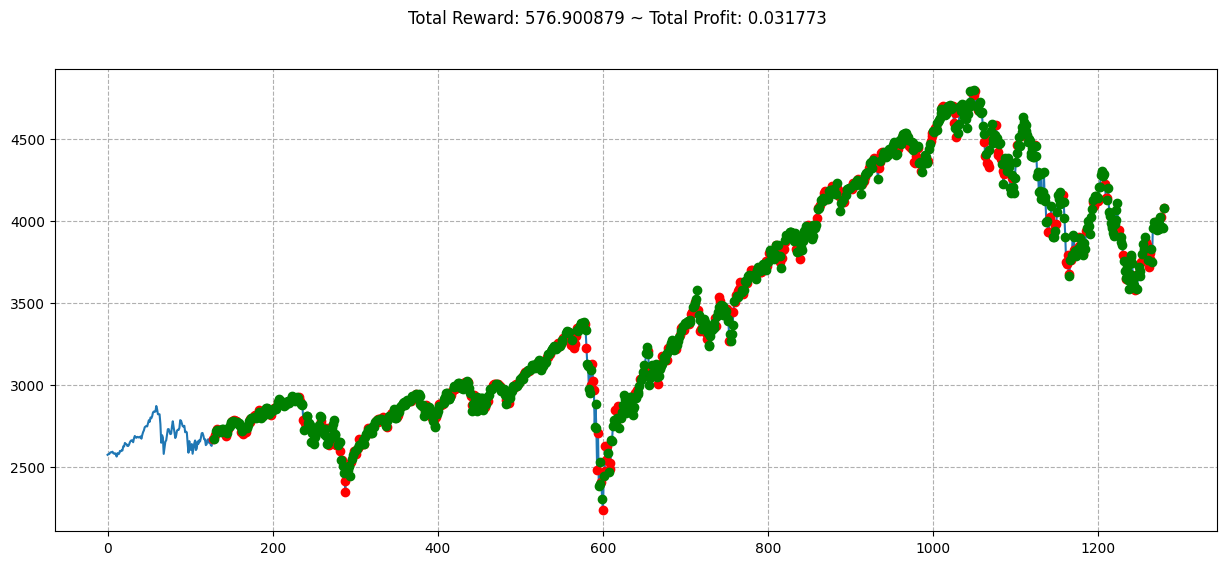

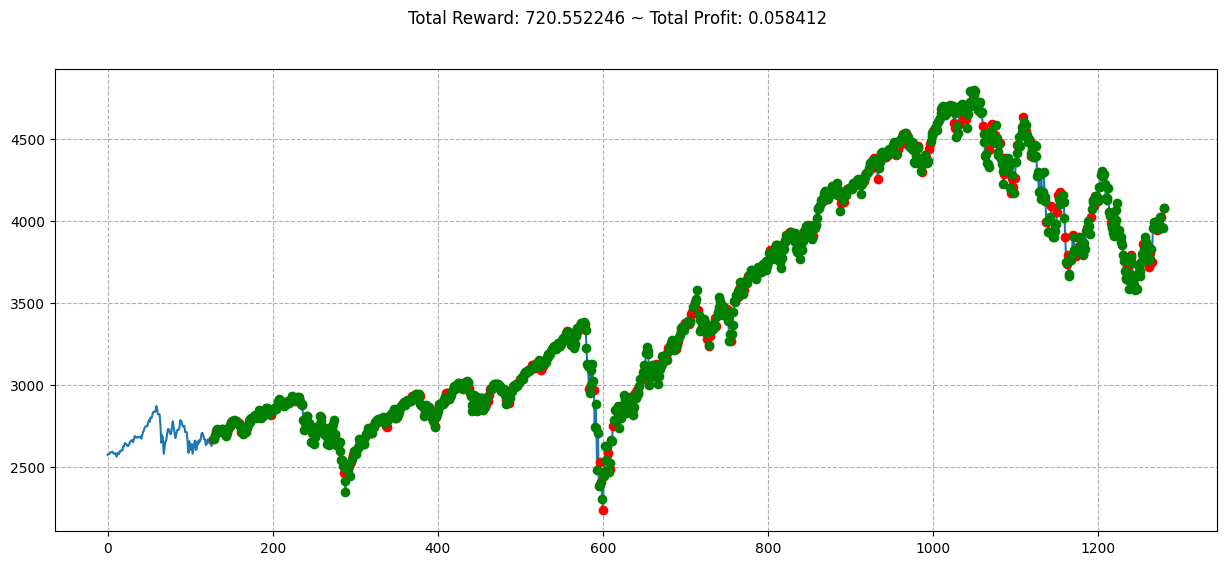

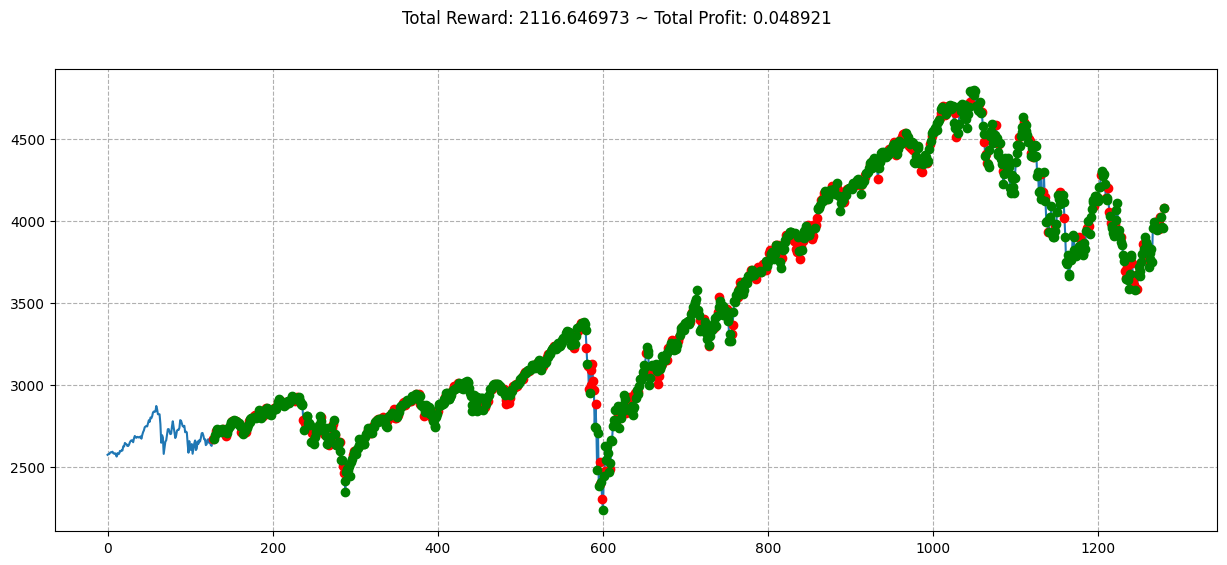

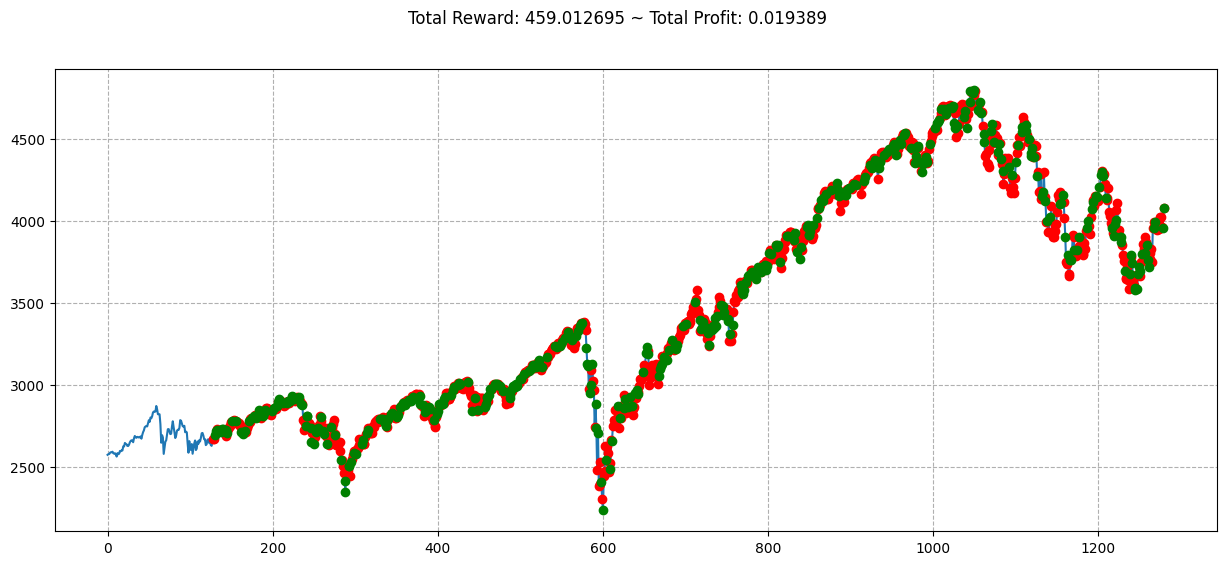

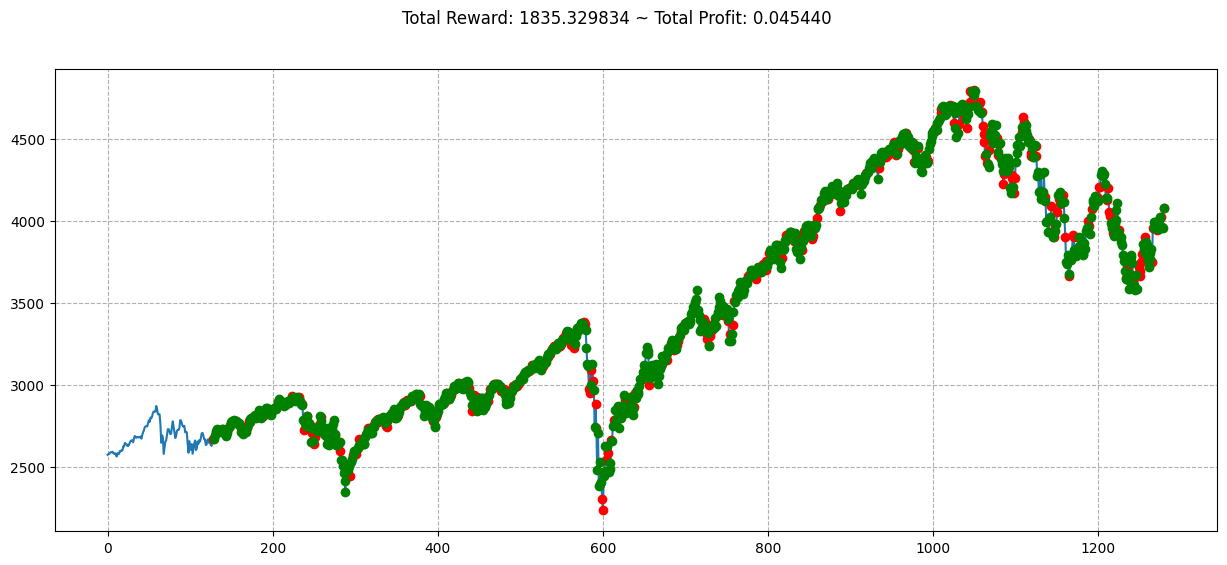

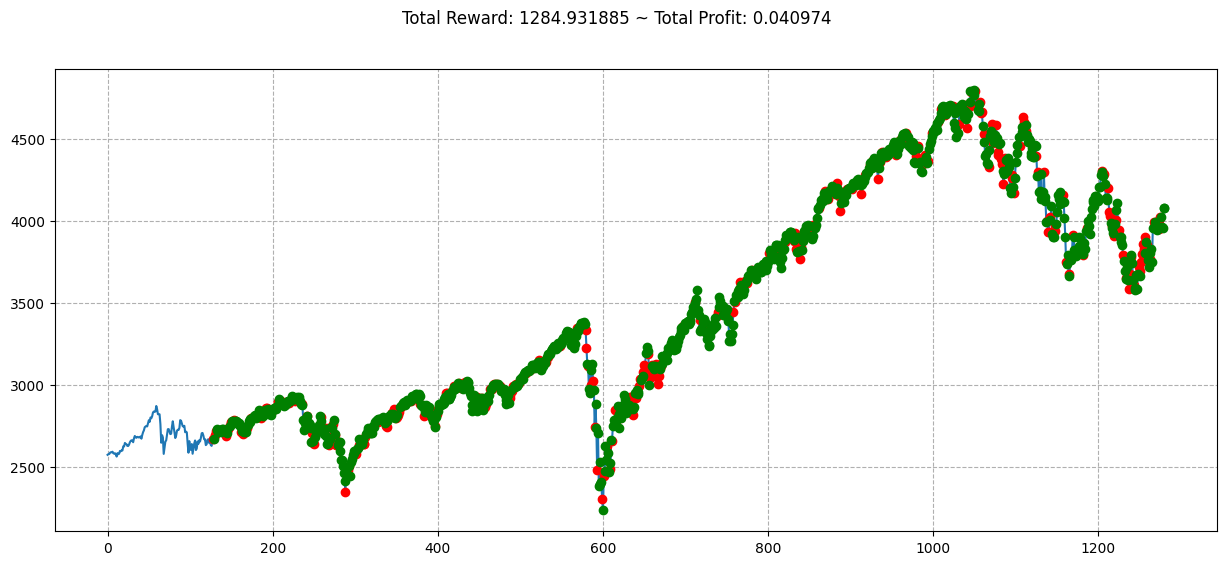

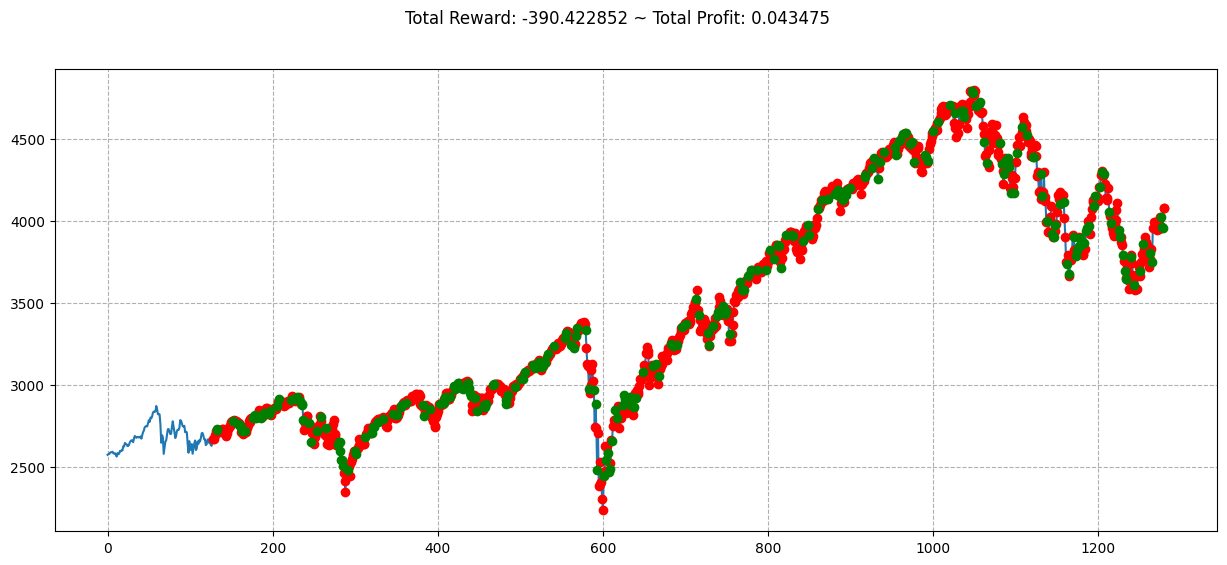

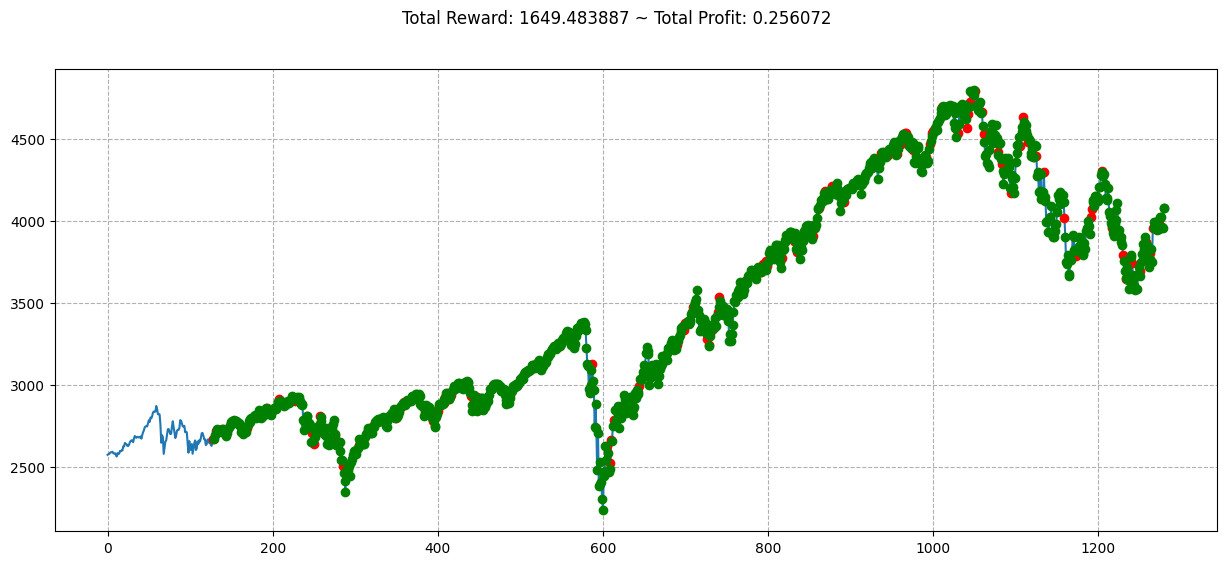

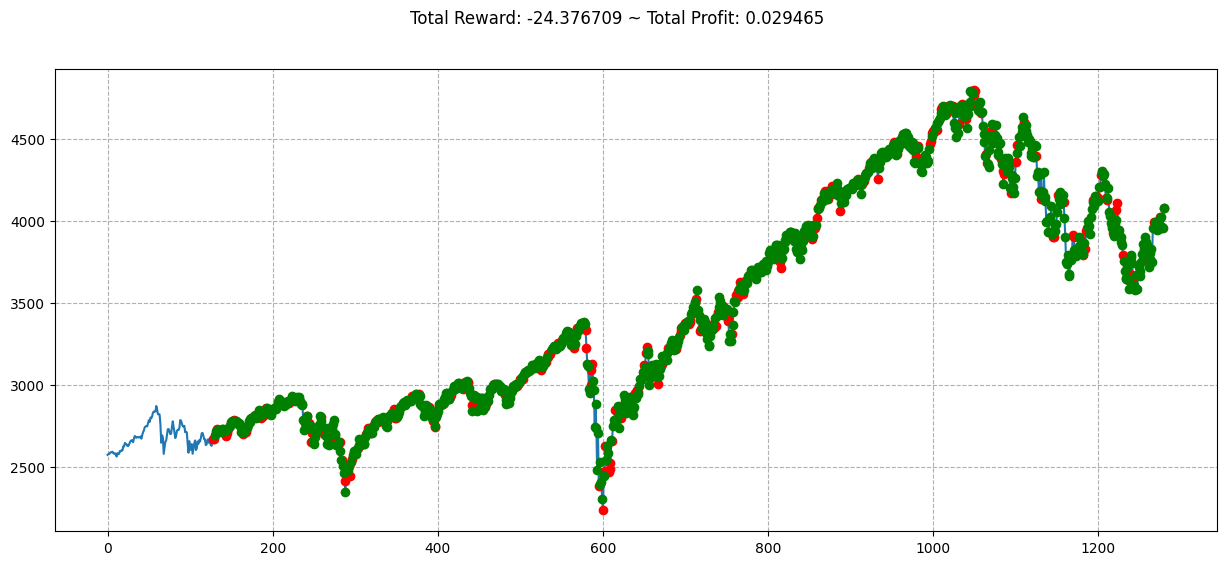

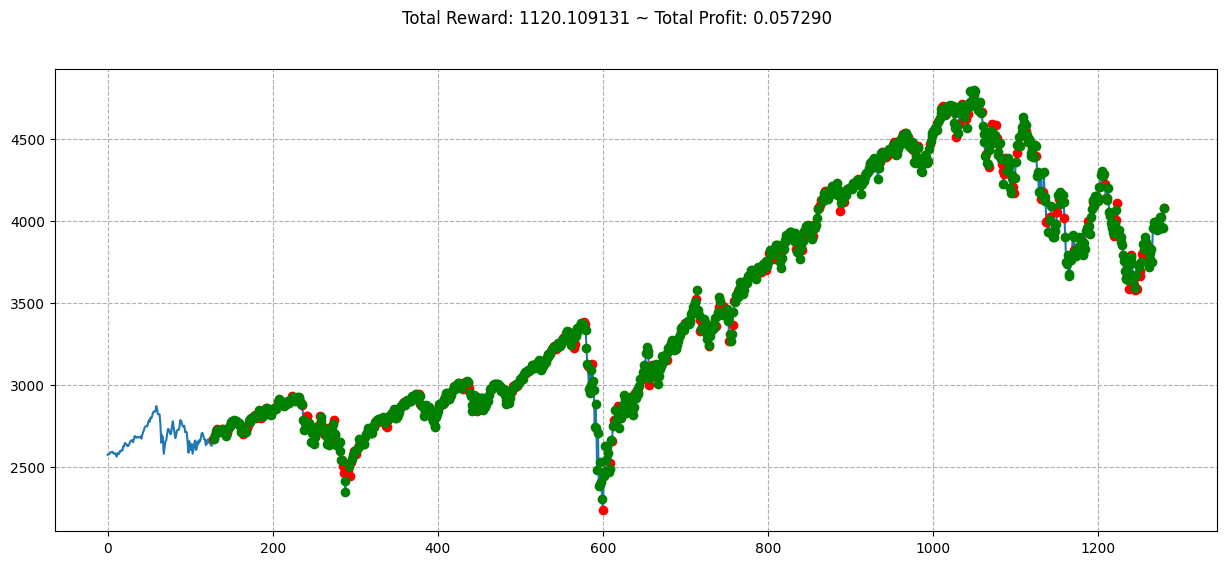

In [15]:
data = ["total_reward", "total_profit", "position", "num_epochs", "learning_rate", "num_time_steps", "time"]
with open('results/tables/results_indicators_lr.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(data)

data_results = {
    "num_epochs": 10,
    "learning_rate": 0,
    "num_time_steps": 100_000
}

for lr in range(1, 11, 1):
    lr = lr/10000

    start=time.time()
    
    data_results["learning_rate"] = lr
    print(f"Learning Rate: {lr}")

    # Creation of the environment 
    env_maker = lambda: CustomEnv(df=df_train, window_size=128, frame_bound=(128, len(df_train)))
    env = DummyVecEnv([env_maker])

    # Training
    model = RecurrentPPO(policy="MlpLstmPolicy", env=env, verbose=0, learning_rate=lr, batch_size=64, n_epochs=10)
    model.learn(total_timesteps=100_000)

    # Evaluate / Store the results
    env = CustomEnv(df=df, window_size=128, frame_bound=(len(df_train), len(df_train)+len(df_test)))
    obs = env.reset()
    while True:
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action=action)
        if done:
            print("info", info)
            break
    
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.grid(linestyle="--")
    plt.savefig(
        fname=f"results/images/PPO_LSTM_Indicators_{lr}lr.png", 
        dpi="figure", 
        format="png", 
        bbox_inches="tight",
        transparent=True
    )

    data_results["time"] = time.time() - start

    info.update(data_results)
    
    results = pd.DataFrame(info, index=[0])
    results.to_csv("results/tables/results_indicators_lr.csv",mode="a", index=False, header=False)

In [16]:
_states

(array([[[ 0.       , -0.7615942,  0.       ,  0.       ,  0.7615942,
           0.7615942,  0.       , -0.7615942, -0.7615942,  0.       ,
           0.       ,  0.7615942, -0.       ,  0.       ,  0.       ,
           0.7615942,  0.7615942,  0.       ,  0.       ,  0.       ,
           0.7615942,  0.       , -0.7615942, -0.       , -0.       ,
           0.7615942,  0.       ,  0.7615942,  0.       ,  0.       ,
          -0.7615942, -0.       , -0.       ,  0.       , -0.7615942,
           0.       , -0.7615942, -0.       ,  0.7615942,  0.       ,
           0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
           0.       ,  0.       , -0.7615942,  0.       ,  0.       ,
          -0.       ,  0.       ,  0.       ,  0.7615942,  0.7615942,
           0.       ,  0.       ,  0.7615942,  0.       ,  0.       ,
           0.       , -0.7615942,  0.       ,  0.       ,  0.       ,
           0.7615942,  0.       ,  0.       , -0.       , -0.7615942,
           0.       

In [15]:
model = RecurrentPPO(policy="MlpLstmPolicy", env=env, verbose=0, learning_rate=0.001, batch_size=64, n_epochs=10)
model.learn(total_timesteps=100_000)

KeyboardInterrupt: 

# Evaluation

info {'total_reward': 1473.15234375, 'total_profit': 0.08207493155709585, 'position': 1}


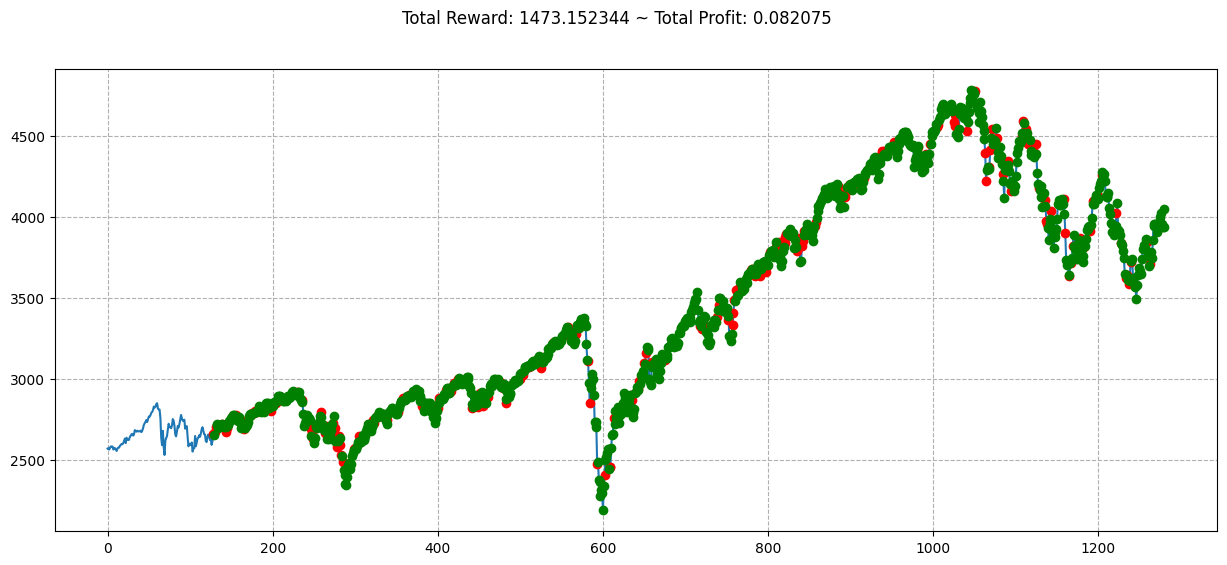

In [16]:
env = CustomEnv(df=df, window_size=128, frame_bound=(len(df_train), len(df_train)+len(df_test)))
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action=action)
    if done:
        print("info", info)
        break
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.grid(linestyle="--")